In [1]:
from tkinter import *
from PIL import ImageTk
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from differential_evolution import differential_evolution
from PIL import ImageTk
import PIL.Image

In [2]:
def load_model():
    model = tf.keras.models.load_model('/Users/raffaelerusso/Desktop/Uni/ro/RO-progetto/ModelloPesi/mnist_model.h5')
    model.load_weights('/Users/raffaelerusso/Desktop/Uni/ro/RO-progetto/ModelloPesi/mnist_weights.h5')
    return model

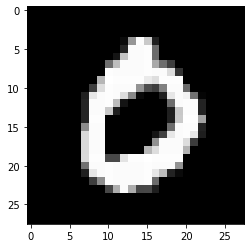

In [3]:
pic = plt.imread("3.png")
plt.imshow(pic,cmap ='gray')

In [4]:
model = load_model()

2022-06-18 16:09:22.310646: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-18 16:09:22.311314: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [5]:
new_pic = np.float32(np.reshape(pic,(1,28,28,1)))

In [6]:
target = print(np.argmax(model.predict(new_pic),axis = 1))


[0]


In [7]:
print(np.argmax(model.predict(new_pic),axis = 1))

[0]


In [8]:
a = PIL.Image.open("3.png")

In [9]:
def perturb_image(xs, img):
    # Controllo se il numero di pixel perturbati è pari solo a uno e in tal caso
    # lo trasformo in una lista per lasciare inalterato il calcolo
    if xs.ndim < 2:
        xs = np.array([xs])
       
    #Copio l'immagine immagine  n == len(xs) volte per creare n immagini perturbate(inutilizzato)
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
   
    # La perturbazione deve essere intera
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs): #ottengo (vettore_perturbazioni x - immagine da perturbare(qui una))

        # Split di x in un'array di 3 elementi ciascuno, ossia per la singola perturbazione 
        # i.e [[x,y,z], ...]
        pixels = np.split(x, len(x) // 3) 
        for pixel in pixels:
            #A ogni pixel (x,y) assegno il suo livello di grigio z
            x_pos, y_pos, *gray = pixel  #[x,y,z]
            img[x_pos, y_pos] = gray
    
    return imgs

def predict_classes(xs, img, target_class, model):
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    return predictions 
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)

    if verbose:
        print('Confidence:', round(confidence[target_class],ndigits=3))
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):  
        return True 

def attack(classe,img, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Seleziono la classe target a seconda che l'attacco sia targeted o untargeted 
    targeted_attack = target is not None
    target_class = target if targeted_attack else int(classe)
    
    # Definisco vettore perturbazione
    bounds = [(0,28), (0,28), (0,2)] * pixel_count
    
    # Moltiplicatore della popolazione a seconda della dimensione del vettore di perturbazione
    popmul = max(1, popsize // len(bounds))
    
    img = np.reshape(img,(1,28,28,1))
    
    # Funzioni ausiliarie per l'algoritmo evoluzione differenziale
    def predict_fn(xs): #nella forma f(x,args) dove x è un vettore 1d 
        return predict_classes(xs, img, target_class, 
                               model)
    
    def callback_fn(x, convergence): #quando ritorna True l'algoritmo termina
        return attack_success(x, img, target_class, 
                              model, targeted_attack, verbose)
    
    #Differential Evolution
    attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize= popmul,mutation=1,recombination = 1, atol = -1, callback=callback_fn, polish=False)

    
    # Calcolo statistiche
    attack_image = perturb_image(attack_result.x, img)[0]
    prior_probs = model.predict(img)
    
    attack_image = np.reshape(attack_image,(1,28,28,1))
    predicted_probs = model.predict(attack_image)
  
    predicted_class = np.argmax(predicted_probs)
    actual_class = int(classe)
    success = predicted_class != actual_class
    
    return [attack_image, pixel_count, classe, actual_class, predicted_class, success, prior_probs, predicted_probs, attack_result.x]
   

In [10]:
pic = plt.imread("3.png")
new_pic = np.float32(np.reshape(pic,(1,28,28,1)))
target = print(np.argmax(model.predict(new_pic),axis = 1))
result =  attack(0, pic,model, pixel_count=50,maxiter=100,popsize=100,target = None, verbose=True)


[0]
Confidence: 0.495
Confidence: 0.495
Confidence: 0.495
Confidence: 0.495
Confidence: 0.495
Confidence: 0.279


In [12]:
from tkinter import *

from PIL import ImageTk, Image    

def click_menu(choice):
        choice = variable.get()
        print(choice)

def showImage():
        link = path.get()
        my_img = ImageTk.PhotoImage(Image.open(link).resize((112,112)))
        lbl1.configure(image=my_img)
        lbl1.image = my_img

        #btn = Button(c, text="Load pic", command=showImage)
        #btn.grid(column=1, row=2, sticky=N, pady=5, padx=5)
        model = load_model()
        pic = plt.imread(link)
        new_pic = np.float32(np.reshape(pic,(1,28,28,1)))
        result =  attack(variable.get(), new_pic,model, pixel_count=50,maxiter=100,popsize=100,target = None, verbose=True)
        #plt.figure(1)
        #plt.imshow(np.reshape(result[0],(28,28)))
        #plt.show()
        print(result[0])
        img_att = np.int32(result[0]*255)
        img_att = np.reshape(img_att,(28,28))
        img_att = ImageTk.PhotoImage(PIL.Image.fromarray(img_att).resize((112,112)))
        lbl2.configure(image=img_att)
        lbl2.image = img_att
        classe_pred.config(text="Classe predetta: " + str(result[4]))
        #classe_pred.grid(column=1,row=0)

root = Tk()  
root.title('MNIST ADV EXAMPLE')
root.geometry("400x250")
c = Frame(root)
c.grid(column=0, row=0, sticky=(N,W,E,S))
root.grid_columnconfigure(0, weight=1)
root.grid_rowconfigure(0,weight=1)
path = Entry(c)
path.insert(0,"3.png")
path.grid(row = 0,column=0)
btn = Button(c, text="Load pic", command=showImage)
btn_quit = Button(c, text="Quit", command=root.quit)
lbl1 = Label(c)

classe_pred = Label(c,text="Classe predetta: ")


variable = IntVar(c)
variable.set(1) # default value

classe = OptionMenu(c,variable,0, 1, 2, 3,4,5,6,7,8,9,command=click_menu)
classe.grid(column=0,row=3)


btn.grid(column=0, row=1, sticky=N, pady=5, padx=5)
btn_quit.grid(column=1, row=0, sticky=N, pady=5, padx=5)
lbl1.grid(column=0, row=2, sticky=N, pady=5, padx=5)

#predizione
lbl2 = Label(c)
lbl2.grid(column=1, row=2, sticky=N, pady=5, padx=5)
classe_pred.grid(column=1,row=1)

bg = ImageTk.PhotoImage(Image.open("rsz_bg.jpg").resize((112,112)))
lbl1.configure(image=bg)
lbl1.image = bg
lbl2.configure(image=bg)
lbl2.image = bg



root.mainloop()

0
Confidence: 0.697
Confidence: 0.65
Confidence: 0.497
Confidence: 0.497
Confidence: 0.497
Confidence: 0.497
Confidence: 0.497
Confidence: 0.497
Confidence: 0.497
Confidence: 0.497
Confidence: 0.497
Confidence: 0.497
Confidence: 0.471
Confidence: 0.471
Confidence: 0.471
Confidence: 0.471
Confidence: 0.471
Confidence: 0.471
Confidence: 0.471
Confidence: 0.471
Confidence: 0.364
[[[[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.     

: 